# Data Collection

In [13]:
!pip install numpy==1.23.5

  Obtaining dependency information for numpy==1.23.5 from https://files.pythonhosted.org/packages/b8/d0/e6a2cb9a3f3e863a43e50949e9ae704be70baf398fd5af59355f65c8740a/numpy-1.23.5-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [1]:
!pip install opencv-python
!pip install tensorflow
import os
import cv2
import numpy as np
import pandas as pd
import zipfile
from tensorflow.keras.utils import to_categorical

#  Define the path for the zip file and extraction directory
zip_path = r"/Users/saibhargav/Downloads/GTSRB/GTSRB_Final_Training_Images.zip"  # Use raw string for Windows paths
extract_dir = r"/Users/saibhargav/Downloads/GTSRB/Final_Training_Images"



# Extract the dataset if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(r"/Users/saibhargav/Downloads/GTSRB/Final_Training_Images")

#  Path to GTSRB training data
train_root = extract_dir


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
import os

# Check if extraction was successful
if os.path.exists(extract_dir):
    print(" Extraction successful. Checking dataset structure...")
    print("Classes found:", os.listdir(extract_dir))  # Should list class folders
else:
    print(" Extraction failed. Check the ZIP file.")

 Extraction successful. Checking dataset structure...
Classes found: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [3]:
import os

dataset_path = r"C:\Users\Sai Vaishnavi\GTSRB\Final_Training\Images"

# Verify folder contents
print("Checking dataset structure...")
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    print(f" {folder} - {'Folder' if os.path.isdir(folder_path) else 'File'}")

# Pick a class and check images inside
sample_class = os.listdir(dataset_path)[0]  # First class folder
sample_class_path = os.path.join(dataset_path, sample_class)

print(f"\n Checking images inside {sample_class}...")
print(os.listdir(sample_class_path)[:5])  # Show first 5 files

Checking dataset structure...
 GTSRB - Folder

 Checking images inside GTSRB...
['.ipynb_checkpoints', 'Final_Training']


In [4]:

#  Load and preprocess images
def load_gtsrb_dataset(root_dir, img_size=(32, 32)):
    images, labels = [], []  # FIXED
    for class_id in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.endswith(".ppm"):
                    img_path = os.path.join(class_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        images.append(img)
                        labels.append(int(class_id))
    return np.array(images), np.array(labels)

# Load data
X_raw, y_raw = load_gtsrb_dataset(train_root)
print(f"Loaded {len(X_raw)} images, shape: {X_raw.shape}")

#  Display class-wise distribution
label_counts = np.bincount(y_raw)
label_df = pd.DataFrame({
    "ClassId": np.arange(len(label_counts)),
    "Image Count": label_counts
})
print("\nClass-wise Image Distribution:")
print(label_df.to_string(index=False))


Loaded 39209 images, shape: (39209, 32, 32, 3)

Class-wise Image Distribution:
 ClassId  Image Count
       0          210
       1         2220
       2         2250
       3         1410
       4         1980
       5         1860
       6          420
       7         1440
       8         1410
       9         1470
      10         2010
      11         1320
      12         2100
      13         2160
      14          780
      15          630
      16          420
      17         1110
      18         1200
      19          210
      20          360
      21          330
      22          390
      23          510
      24          270
      25         1500
      26          600
      27          240
      28          540
      29          270
      30          450
      31          780
      32          240
      33          689
      34          420
      35         1200
      36          390
      37          210
      38         2070
      39          300
      40          3

# Data Cleaning

In [5]:
import glob

#  Clean using CSV ROI data
def load_and_crop_with_roi(root_dir, img_size=(32, 32)):
    images, labels = [], []

    # Get all class CSVs
    csv_files = glob.glob(os.path.join(root_dir, "*", "GT-*.csv"))

    for csv_path in csv_files:
        df = pd.read_csv(csv_path, sep=';')
        class_dir = os.path.dirname(csv_path)

        for _, row in df.iterrows():
            img_path = os.path.join(class_dir, row['Filename'])
            img = cv2.imread(img_path)

            if img is not None:
                # Crop using ROI
                x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
                cropped = img[y1:y2, x1:x2]
                resized = cv2.resize(cropped, img_size)
                resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
                images.append(resized)
                labels.append(row['ClassId'])

    return np.array(images)/255.0, np.array(labels)

#  Load cleaned dataset
X_cleaned, y_cleaned = load_and_crop_with_roi(train_root)
print(f" Cropped and resized {len(X_cleaned)} images, shape: {X_cleaned.shape}")


 Cropped and resized 39209 images, shape: (39209, 32, 32, 3)


# Data Transformation

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import requests
import numpy as np

#  One-hot encode labels
y_encoded = to_categorical(y_cleaned)
print(f" Labels one-hot encoded: shape = {y_encoded.shape}")

#  Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_encoded, test_size=0.2, stratify=y_cleaned, random_state=42
)
print(f" Split: {X_train.shape[0]} train, {X_test.shape[0]} test")

#  Real-time Weather API Integration
API_KEY = "4690348b38a4f5520d615776d7e9e01d"  
CITY = "Texas"
API_URL = "https://api.openweathermap.org/data/2.5/weather"

def get_weather():
    try:
        params = {"q": CITY, "appid": API_KEY, "units": "metric"}
        response = requests.get(API_URL, params=params)
        data = response.json()
        if response.status_code == 200:
            temp = data["main"].get("temp", 20.0)
            humidity = data["main"].get("humidity", 50)
            print(f" Temp: {temp}°C,  Humidity: {humidity}%")
            return temp, humidity
    except Exception as e:
        print(" Weather API error:", e)
    return 20.0, 50

# Fetch real-time weather (assumed constant for training batch)
temperature, humidity = get_weather()
weather_train = np.array([[temperature, humidity]] * len(X_train))
weather_test = np.array([[temperature, humidity]] * len(X_test))

print(f" Weather metadata shape (train): {weather_train.shape}")


 Labels one-hot encoded: shape = (39209, 43)
 Split: 31367 train, 7842 test
 Temp: 21.97°C,  Humidity: 73%
 Weather metadata shape (train): (31367, 2)


In [7]:
# Augmentation

In [8]:
# After Step 3 is done — you already have these
# X_train, y_train, weather_train
# (All numpy arrays)

# INSERT AUGMENTATION HERE 
import random

def add_fog(image):
    fog_layer = np.full_like(image, 200, dtype=np.uint8)
    return cv2.addWeighted(image, 0.7, fog_layer, 0.3, 0)

def add_rain(image, drop_count=100):
    rainy = image.copy()
    h, w, _ = image.shape
    for _ in range(drop_count):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = x1 + random.randint(-2, 2), y1 + random.randint(10, 20)
        cv2.line(rainy, (x1, y1), (x2, y2), (200, 200, 200), 1)
    return cv2.addWeighted(image, 0.8, rainy, 0.2, 0)

def add_glare(image):
    glare = image.copy()
    h, w = glare.shape[:2]
    cx = random.randint(w//3, 2*w//3)
    cy = random.randint(h//3, 2*h//3)
    r = random.randint(5, 15)
    overlay = glare.copy()
    cv2.circle(overlay, (cx, cy), r, (255, 255, 255), -1)
    return cv2.addWeighted(glare, 0.8, overlay, 0.2, 0)

# Augment 25% of training data
augment_fraction = 0.25
num_aug = int(len(X_train) * augment_fraction)
indices = random.sample(range(len(X_train)), num_aug)

X_aug, y_aug = [], []

for idx in indices:
    img = (X_train[idx] * 255).astype(np.uint8)
    label = y_train[idx]
    effect = random.choice(["fog", "rain", "glare"])
    
    if effect == "fog":
        aug_img = add_fog(img)
    elif effect == "rain":
        aug_img = add_rain(img)
    else:
        aug_img = add_glare(img)

    X_aug.append(aug_img / 255.0)
    y_aug.append(label)

# Final combined training data
X_train_aug = np.concatenate((X_train, np.array(X_aug)), axis=0)
y_train_aug = np.concatenate((y_train, np.array(y_aug)), axis=0)
weather_train_aug = np.concatenate((weather_train, weather_train[:len(X_aug)]), axis=0)

print(f" Augmented {len(X_aug)} images. Final training shape: {X_train_aug.shape}")


 Augmented 7841 images. Final training shape: (39208, 32, 32, 3)


In [9]:
# Display Augmented Images

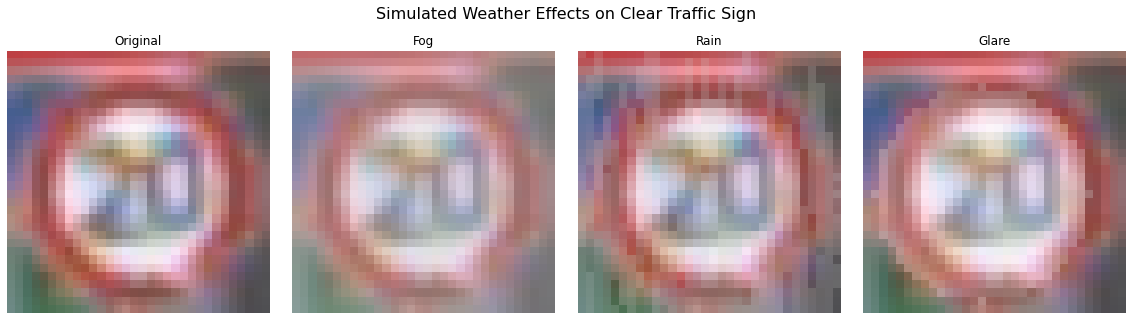

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Weather effect functions ---
def add_fog(image):
    fog_layer = np.full_like(image, 200, dtype=np.uint8)
    return cv2.addWeighted(image, 0.7, fog_layer, 0.3, 0)

def add_rain(image, drop_count=100):
    rainy = image.copy()
    h, w, _ = image.shape
    for _ in range(drop_count):
        x1, y1 = random.randint(0, w), random.randint(0, h)
        x2, y2 = x1 + random.randint(-2, 2), y1 + random.randint(10, 20)
        cv2.line(rainy, (x1, y1), (x2, y2), (200, 200, 200), 1)
    return cv2.addWeighted(image, 0.8, rainy, 0.2, 0)

def add_glare(image):
    glare = image.copy()
    h, w = glare.shape[:2]
    cx = random.randint(w // 3, 2 * w // 3)
    cy = random.randint(h // 3, 2 * h // 3)
    radius = random.randint(5, 15)
    overlay = glare.copy()
    cv2.circle(overlay, (cx, cy), radius, (255, 255, 255), -1)
    return cv2.addWeighted(glare, 0.8, overlay, 0.2, 0)

# --- Sharp image filter ---
def is_clear_image(img, threshold=100.0):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() > threshold

def get_one_clear_image(X):
    for i in range(len(X)):
        img = (X[i] * 255).astype(np.uint8)
        if is_clear_image(img):
            return img
    return None

# --- Select and visualize one image with 4 versions ---
base_img = get_one_clear_image(X_cleaned)

if base_img is not None:
    fog = add_fog(base_img)
    rain = add_rain(base_img)
    glare = add_glare(base_img)

    images = [base_img, fog, rain, glare]
    titles = ["Original", "Fog", "Rain", "Glare"]

    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.suptitle("Simulated Weather Effects on Clear Traffic Sign", fontsize=16, y=1.10)
    plt.show()
else:
    print(" No clear image found in the dataset.")


# Model Training (CNN + Weather Input)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate

def build_weather_aware_model(img_shape=(32, 32, 3), weather_shape=(2,), num_classes=43):
    #  CNN Branch for images
    cnn_input = Input(shape=img_shape)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(128, activation='relu')(x)
    cnn_output = Dropout(0.5)(cnn_output)

    #  DNN Branch for weather metadata
    weather_input = Input(shape=weather_shape)
    weather_dense = Dense(8, activation='relu')(weather_input)

    #  Fusion
    merged = Concatenate()([cnn_output, weather_dense])
    final_output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[cnn_input, weather_input], outputs=final_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#  Build the model
model = build_weather_aware_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 30, 30, 32)        │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 15, 15, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 13, 13, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 6, 6, 64)          │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 2304)              │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         295,040 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 2)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 8)                 │              24 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 136)               │               0 │ dropout[0][0],             │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 43)                │           5,891 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 320,347 (1.22 MB)

 Trainable params: 320,347 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [12]:
history = model.fit(
    [X_train_aug, weather_train_aug], y_train_aug,
    epochs=15,
    batch_size=64,
    validation_data=([X_test, weather_test], y_test)
)

Epoch 1/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.1865 - loss: 6.3388 - val_accuracy: 0.8602 - val_loss: 0.6340
Epoch 2/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7399 - loss: 0.8699 - val_accuracy: 0.9373 - val_loss: 0.2430
Epoch 3/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8530 - loss: 0.4941 - val_accuracy: 0.9721 - val_loss: 0.1358
Epoch 4/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8889 - loss: 0.3770 - val_accuracy: 0.9744 - val_loss: 0.1104
Epoch 5/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9076 - loss: 0.3053 - val_accuracy: 0.9819 - val_loss: 0.0831
Epoch 6/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9201 - loss: 0.2654 - val_accuracy: 0.9851 - val_loss: 0.0689
Epoch 7/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9293 - loss: 0.2263 - val_accuracy: 0.9871 - val_loss: 0.0575
Epoch 8/15
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9407 - loss: 0.1915 - val

# Plot Accuracy and Loss

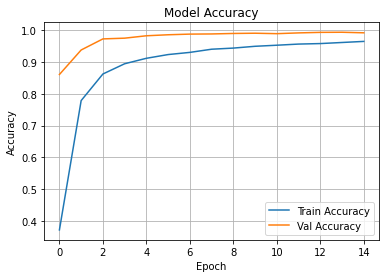

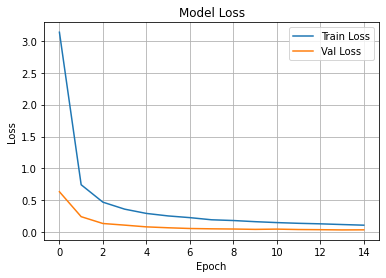

In [13]:
import matplotlib.pyplot as plt

#  Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#

In [14]:
# 6.1. Evaluate on Test Set

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

🎯 Final Test Accuracy: 99.12%

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       1.00      0.99      0.99       444
           2       0.98      0.99      0.99       450
           3       1.00      0.96      0.98       282
           4       0.99      1.00      1.00       396
           5       0.97      0.98      0.97       372
           6       1.00      0.99      0.99        84
           7       0.98      1.00      0.99       288
           8       1.00      0.98      0.99       282
           9       0.99      0.99      0.99       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      0.99      1.00       156
          15       0.98      1.00     

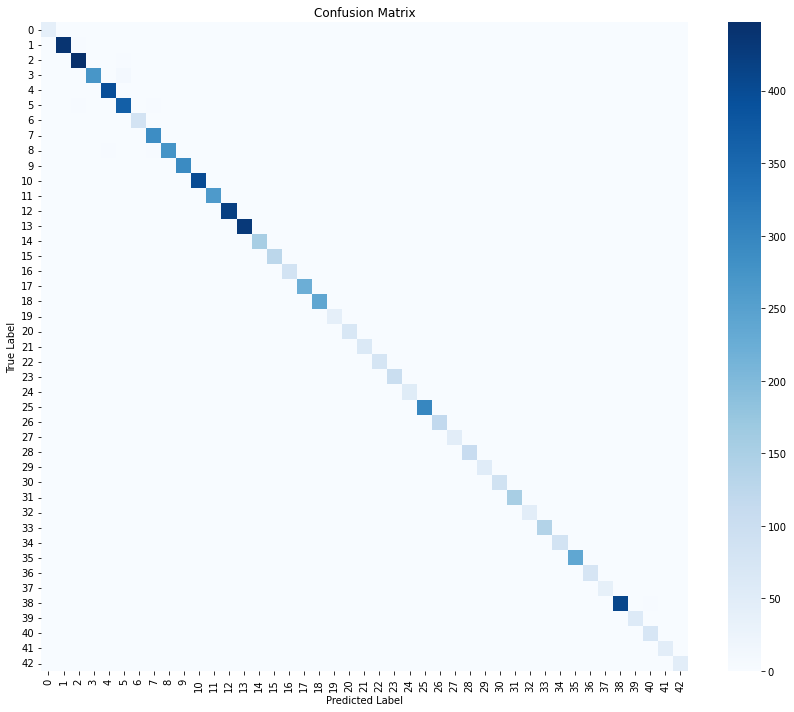

In [15]:
# Final evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on entire test set
y_pred_probs = model.predict([X_test, weather_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Final Test Accuracy: {acc * 100:.2f}%")

# 📄 Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [16]:
# 6.2. Save Model

In [17]:
model.save("weather_augmented_traffic_sign_model.keras")
print(" Final model saved as weather_augmented_traffic_sign_model.keras")

 Final model saved as weather_augmented_traffic_sign_model.keras


In [18]:
# 6.3.  Make a Few Predictions

In [19]:
# Predict on first 10 test samples
y_pred_probs = model.predict([X_test[:10], weather_test[:10]])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test[:10], axis=1)

# Compare predictions vs true
for i in range(10):
    print(f"Image {i+1}: Predicted = {y_pred[i]}, Actual = {y_true[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image 1: Predicted = 28, Actual = 28
Image 2: Predicted = 2, Actual = 2
Image 3: Predicted = 1, Actual = 1
Image 4: Predicted = 25, Actual = 25
Image 5: Predicted = 38, Actual = 38
Image 6: Predicted = 9, Actual = 9
Image 7: Predicted = 31, Actual = 31
Image 8: Predicted = 12, Actual = 12
Image 9: Predicted = 1, Actual = 1
Image 10: Predicted = 4, Actual = 4


In [20]:
# 6.4.  Visual Display

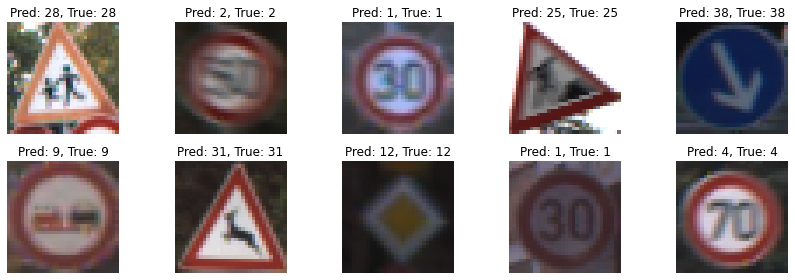

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Pred: {y_pred[i]}, True: {y_true[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
import time
batch_size = 4
X_batch = X_test[:batch_size]
weather_batch = weather_test[:batch_size]
start_time = time.time()
_ = model.predict([X_batch, weather_batch], verbose=0)
total_time = time.time() - start_time
fps = batch_size / total_time
print(f"FPS for {batch_size} frames: {fps:.2f}")

FPS for 4 frames: 44.88


In [23]:
import tensorflow as tf
import time
import numpy as np

batch_size = 4
X_batch = X_test[:batch_size]
weather_batch = weather_test[:batch_size]

# Define the prediction function with tf.function
@tf.function
def predict_fn(inputs):
    return model(inputs, training=False)

# Warm-up to avoid initialization overhead
for _ in range(5):
    _ = predict_fn([X_batch, weather_batch])

# Measure over multiple iterations for accuracy
iterations = 100
start_time = time.perf_counter()  # Higher precision timing
for _ in range(iterations):
    _ = predict_fn([X_batch, weather_batch])
total_time = time.perf_counter() - start_time

# Calculate FPS
if total_time > 0:  # Avoid division by zero
    fps = (batch_size * iterations) / total_time
    print(f"Optimized FPS for {batch_size} frames (over {iterations} iterations): {fps:.2f}")
else:
    print("Execution too fast to measure accurately with current setup.")
    fps_per_run = float('inf')  # Indicates extremely high FPS

Optimized FPS for 4 frames (over 100 iterations): 2686.66


Model loaded successfully.
Please enter the name of the zip file in the notebook's directory (e.g., traffic_signs.zip):
traffic images.zip
Extracted zip file to temporary directory: C:\Users\Sai Vaishnavi\AppData\Local\Temp\tmpvwtj9zg1

Processing image: IMG-20250405-WA0046.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 6, Confidence: 99.64%


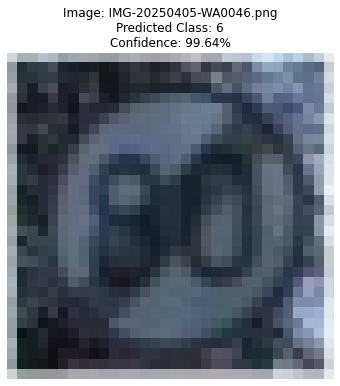


Processing image: IMG-20250405-WA0047.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 7, Confidence: 98.94%


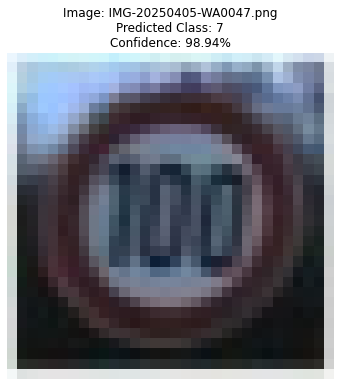


Processing image: IMG-20250405-WA0048.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 30, Confidence: 97.31%


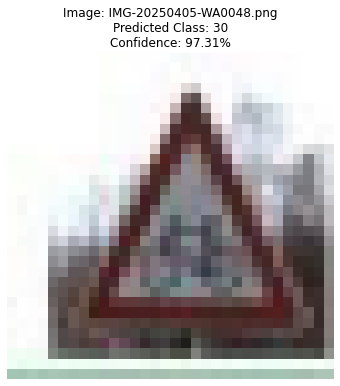


Processing image: IMG-20250405-WA0050.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 16, Confidence: 99.96%


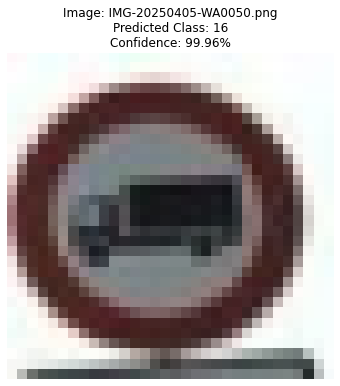


Processing image: IMG-20250405-WA0051.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 11, Confidence: 99.99%


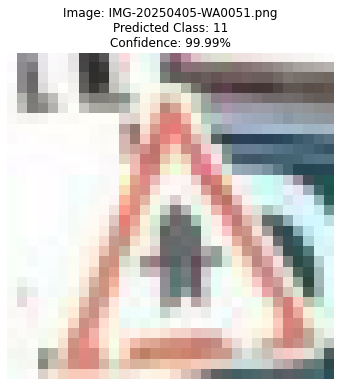


Processing image: IMG-20250405-WA0052.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 25, Confidence: 95.74%


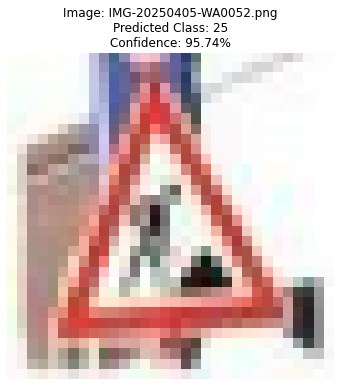


Processing image: IMG-20250405-WA0053.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 27, Confidence: 99.76%


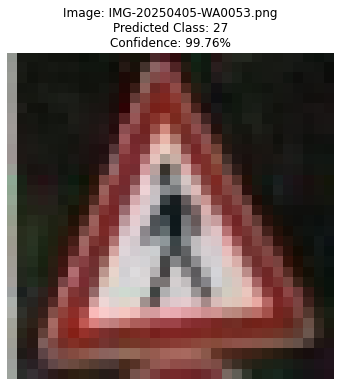


Processing image: IMG-20250405-WA0056.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 31, Confidence: 100.00%


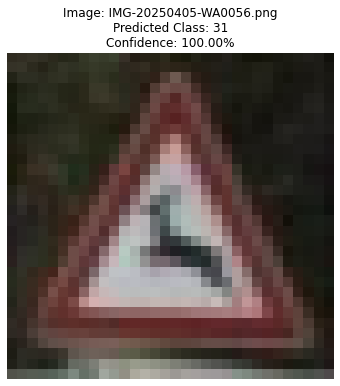


Processing image: IMG-20250405-WA0057.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 34, Confidence: 100.00%


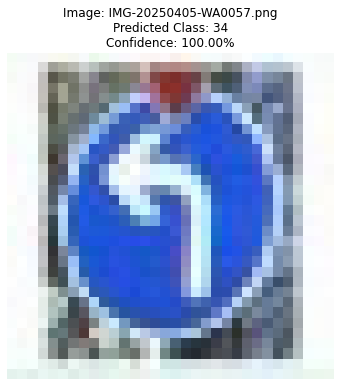


Processing image: IMG-20250405-WA0058.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 21, Confidence: 99.99%


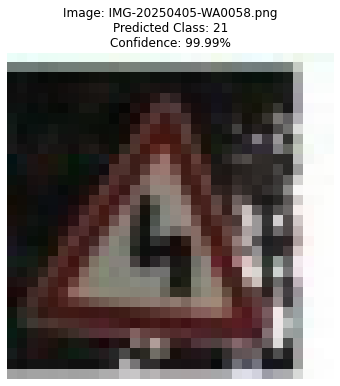


Processing image: IMG-20250405-WA0060.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 4, Confidence: 99.98%


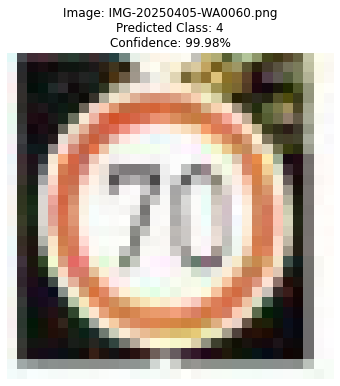


Processing image: IMG-20250405-WA0061.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 8, Confidence: 35.23%


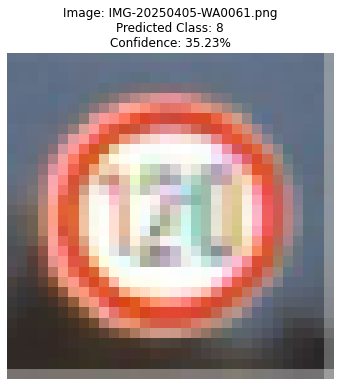


Processing image: IMG-20250405-WA0062.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 17, Confidence: 100.00%


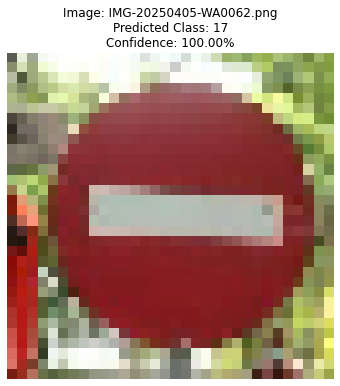


Processing image: IMG-20250405-WA0064.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 0, Confidence: 99.86%


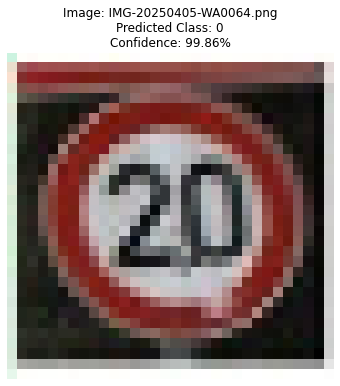


Processing image: IMG-20250405-WA0068.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 1, Confidence: 100.00%


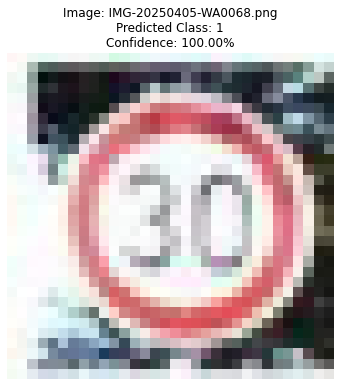


Processing image: IMG-20250405-WA0069.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 3, Confidence: 68.87%


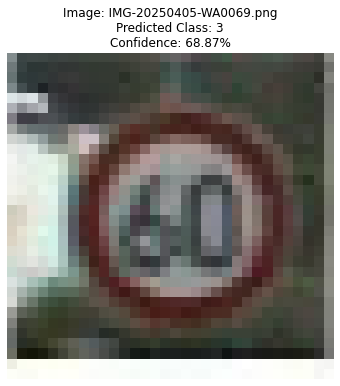


Processing image: IMG-20250405-WA0071.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 5, Confidence: 95.51%


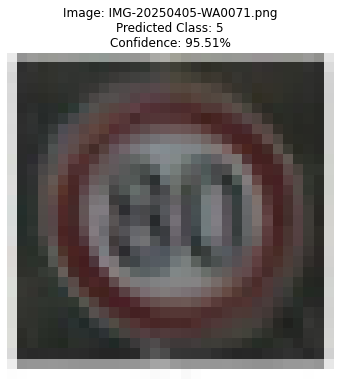


Processing image: IMG-20250405-WA0073.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 14, Confidence: 100.00%


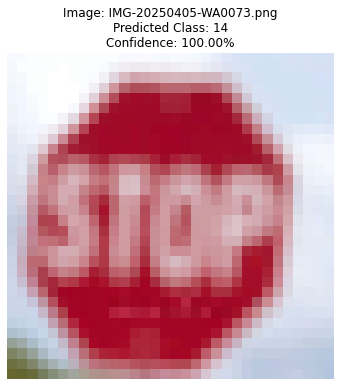


Processing image: IMG-20250405-WA0076.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 14, Confidence: 100.00%


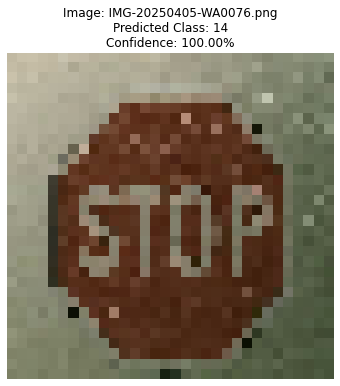


Processing image: IMG-20250405-WA0077.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 11, Confidence: 25.96%


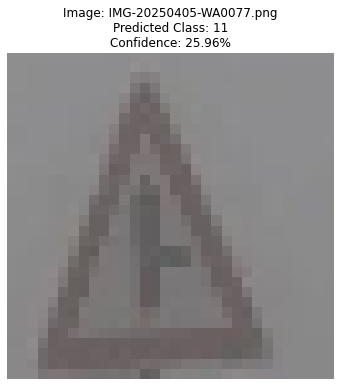


Processing image: IMG-20250405-WA0078.png
Weather in Texas: Temp: 20.97°C, Humidity: 40%
Prediction: Class 2, Confidence: 98.55%


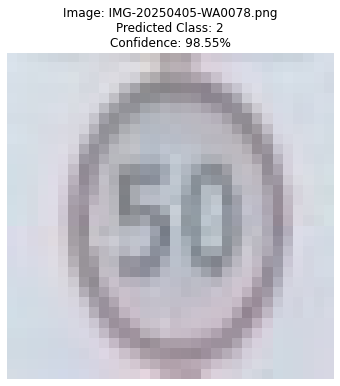

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.models import load_model
from IPython.display import display
import zipfile
import os
import tempfile

# Load the trained model
try:
    model = load_model("weather_augmented_traffic_sign_model.keras")
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Real-time Weather API Integration
API_KEY = "4690348b38a4f5520d615776d7e9e01d"
CITY = "Texas"
API_URL = "https://api.openweathermap.org/data/2.5/weather"

def get_weather():
    try:
        params = {"q": CITY, "appid": API_KEY, "units": "metric"}
        response = requests.get(API_URL, params=params)
        response.raise_for_status()
        data = response.json()
        temp = data["main"].get("temp", 20.0)
        humidity = data["main"].get("humidity", 50)
        print(f"Weather in {CITY}: Temp: {temp}°C, Humidity: {humidity}%")
        return temp, humidity
    except Exception as e:
        print(f"Weather API error: {e}")
        return 20.0, 50

# Preprocess an image
def preprocess_image(img_path, img_size=(32, 32)):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

# Predict traffic sign class
def predict_traffic_sign(img_path):
    try:
        img = preprocess_image(img_path)
        img = np.expand_dims(img, axis=0)
        temperature, humidity = get_weather()
        weather_data = np.array([[temperature, humidity]])
        prediction = model.predict([img, weather_data], verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction) * 100
        return predicted_class, confidence, img[0]
    except Exception as e:
        raise ValueError(f"Prediction error for {img_path}: {e}")

# Visualize the result
def display_result(img, predicted_class, confidence, img_name):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image: {img_name}\nPredicted Class: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

# Process images from zip file
def process_zip_file(zip_path):
    if not os.path.exists(zip_path):
        print(f"Zip file not found at: {zip_path}")
        return
    with tempfile.TemporaryDirectory() as temp_dir:
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.testzip()  # Check for corruption
                zip_ref.extractall(temp_dir)
            print(f"Extracted zip file to temporary directory: {temp_dir}")

            supported_extensions = ('.png', '.jpg', '.jpeg', '.ppm')
            image_found = False
            for root, _, files in os.walk(temp_dir):
                for file in files:
                    if file.lower().endswith(supported_extensions):
                        image_found = True
                        img_path = os.path.join(root, file)
                        try:
                            print(f"\nProcessing image: {file}")
                            predicted_class, confidence, processed_img = predict_traffic_sign(img_path)
                            print(f"Prediction: Class {predicted_class}, Confidence: {confidence:.2f}%")
                            display_result(processed_img, predicted_class, confidence, file)
                        except Exception as e:
                            print(f"Error processing {file}: {e}")
            if not image_found:
                print("No supported images (.png, .jpg, .jpeg, .ppm) found in the zip file.")
        except zipfile.BadZipFile:
            print(f"Error: The file {zip_path} is not a valid zip file or is corrupted.")
        except Exception as e:
            print(f"Error extracting or processing zip file: {e}")

# Main function to handle input and prediction
def main():
    print("Please enter the name of the zip file in the notebook's directory (e.g., traffic_signs.zip):")
    zip_name = input().strip()
    if not zip_name:
        print("No file name provided. Exiting.")
        return
    zip_path = os.path.join(os.getcwd(), zip_name)
    process_zip_file(zip_path)

# Run the prediction
main()